# Projeto

## Classification

## Gradient Boosting Approach

In [1]:
import dslabs_functions as dslabs
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
import dslabs_functions as dslabs
import pandas as pd

file_tag = "Credit_Score"
## Train - resultado do balancing escolhido (over no nosso caso)
train_filename = "data_preparation_final_results_1/data_preparation_csvs/balancing_csvs/data_balancing_alt2_over.csv"
## ficheiro Teste ao qual nao fazemos balancing
test_filename = "data_preparation_final_results_1/data_preparation_csvs/feat_eng_csvs/test_data_feat_select_alt3_RFE.csv"
target = "Credit_Score"
# default
eval_metric = "accuracy"

trnX: np.ndarray
tstX: np.ndarray
trnY: np.array
tstY: np.array
labels: list
vars: list
trnX, tstX, trnY, tstY, labels, vars = dslabs.read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")
## normal depois de fazer o balancing, ter target ordenado 0 e 1's

Train#=113752 Test#=20000
Labels=[0.0, 1.0]


### Parameters Study

GB best for 1000 trees (d=7 and lr=0.1


<Figure size 600x450 with 0 Axes>

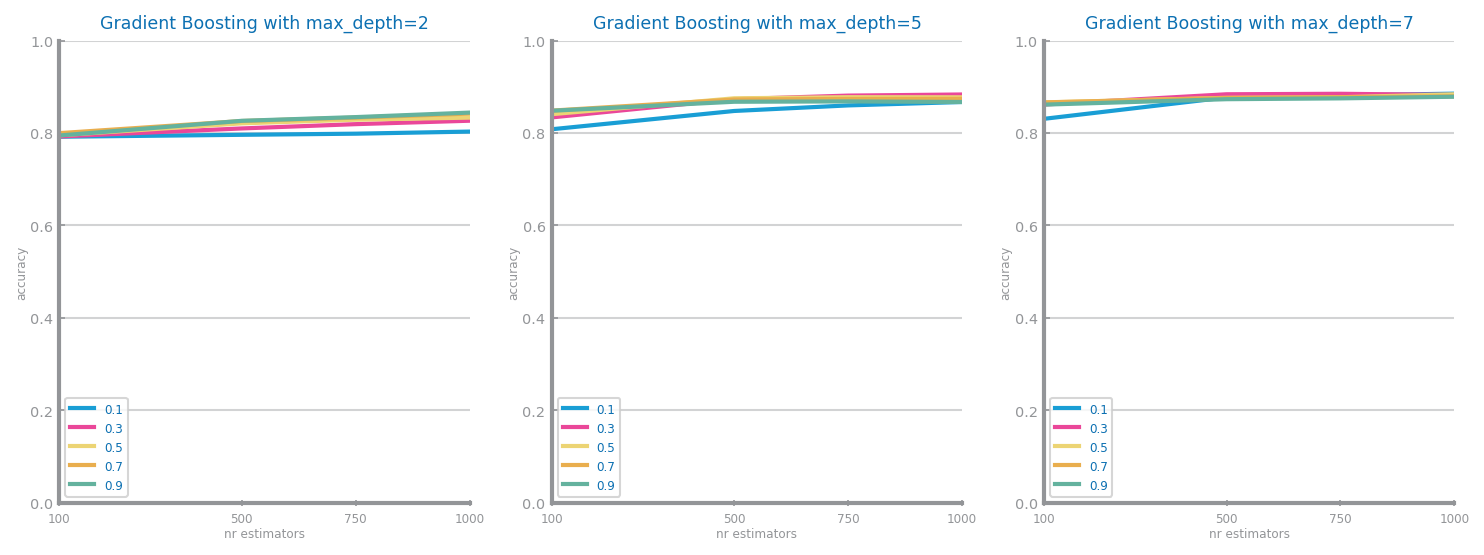

In [2]:
### accuracy
figure()
best_model, params = dslabs.gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_study.png")
show()

GB best for 750 trees (d=7 and lr=0.1


<Figure size 600x450 with 0 Axes>

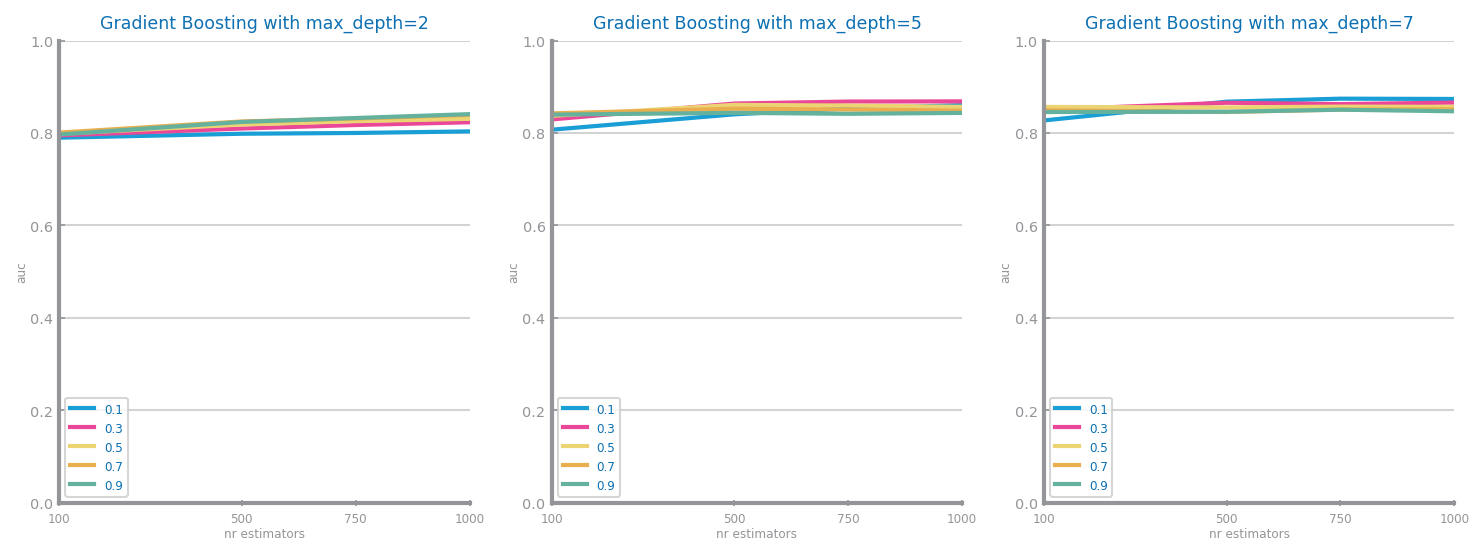

In [3]:
eval_metric="auc"
figure()
best_model, params = dslabs.gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_study.png")
show()

GB best for 750 trees (d=7 and lr=0.3


FileNotFoundError: [Errno 2] No such file or directory: 'classification_images/gradiant_boosting/Credit_Score_gb_f1_study.png'

<Figure size 600x450 with 0 Axes>

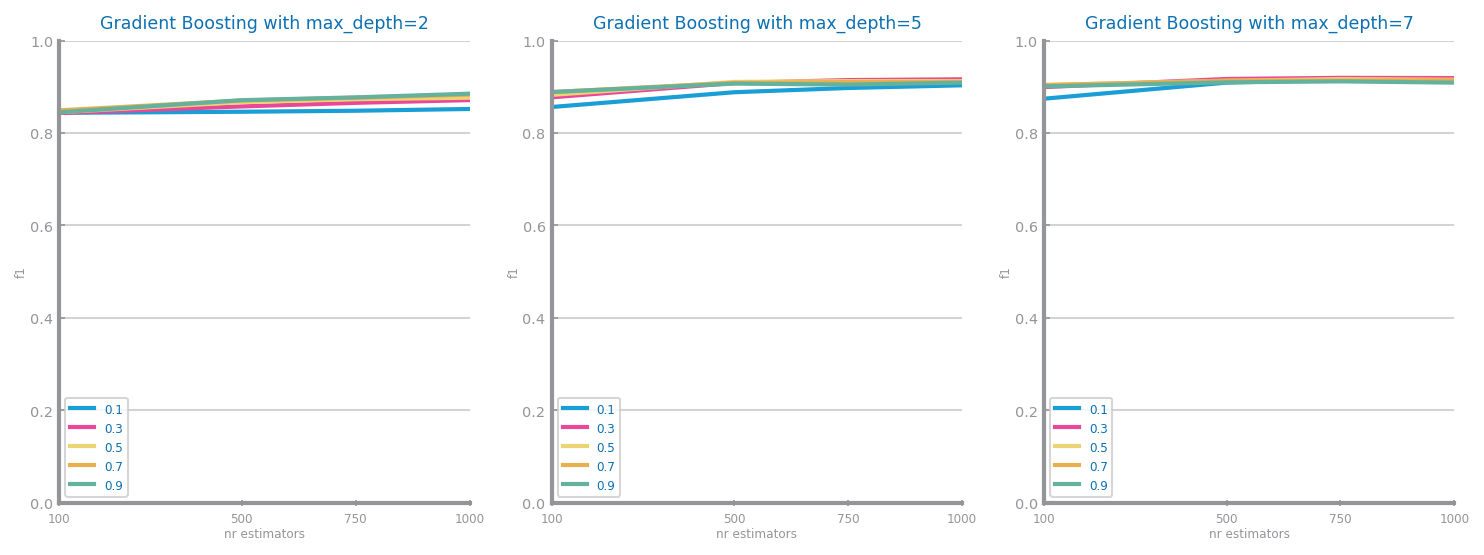

In [4]:
eval_metric="f1"
figure()
best_model, params = dslabs.gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_study.png")
show()

### Recall

GB best for 750 trees (d=7 and lr=0.3


<Figure size 600x450 with 0 Axes>

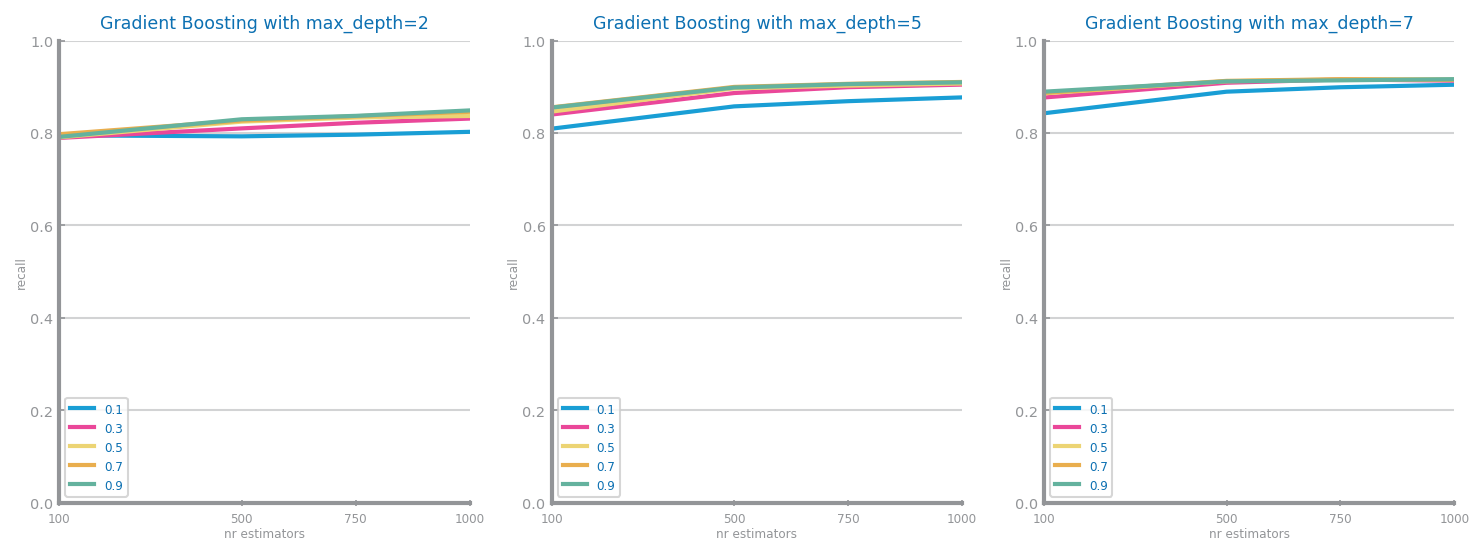

In [5]:
eval_metric="recall"
figure()
best_model, params = dslabs.gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

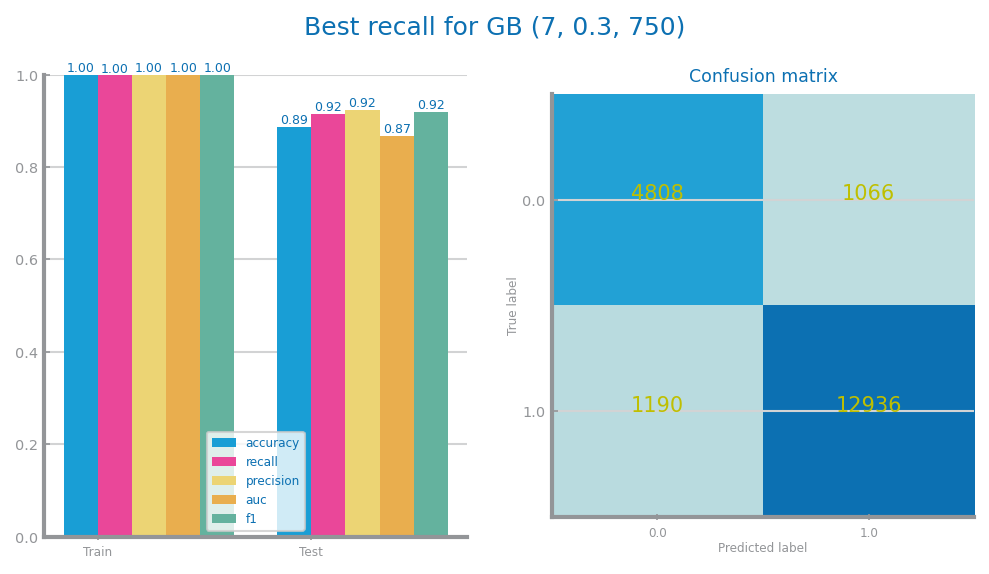

In [6]:
prd_trn: np.array = best_model.predict(trnX)
prd_tst: np.array = best_model.predict(tstX)
figure()
dslabs.plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'classification_images/gradiant_boosting/{file_tag}_gb_{params["name"]}_best_{params["metric"]}_eval.png')
show()

1. OutstandingDebt (0.3168539718709526)
2. CreditMix (0.1182027677458541)
3. Interest_Rate (0.06873032653091314)
4. Delay_from_due_date (0.06391066795133822)
5. Monthly_Inhand_Salary (0.0599845735297108)
6. Credit_History_Age (0.05260954826241108)
7. ChangedCreditLimit (0.049637486286884074)
8. CreditUtilizationRatio (0.033568960942529834)
9. Age (0.033053422693919386)
10. Num_Credit_Card (0.027425972603055522)
11. Month (0.026603930108474186)
12. NumCreditInquiries (0.026167398133018455)
13. Num_Bank_Accounts (0.025706819486561457)
14. Occupation (0.020220802309680742)
15. Payment_Behaviour (0.01424797165537689)
16. Auto Loan (0.007681173925543622)
17. Payday Loan (0.007373540381012368)
18. Personal Loan (0.007251754994527859)
19. Debt Consolidation Loan (0.007074670127180902)
20. Credit-Builder Loan (0.007033344518790212)
21. Student Loan (0.0064757842468155)
22. Mortgage Loan (0.006424145287055825)
23. Home Equity Loan (0.005731224944968223)
24. Not Specified Loan (0.005444528175336

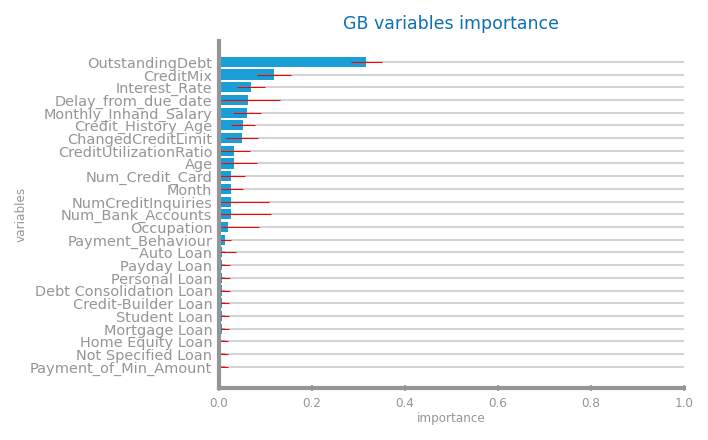

In [7]:
trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(np.std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = np.argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
dslabs.plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_vars_ranking.png")

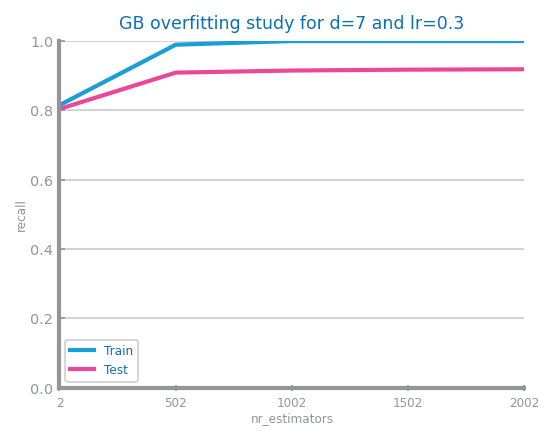

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "recall"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: np.array = clf.predict(tstX)
    prd_trn_Y: np.array = clf.predict(trnX)
    y_tst_values.append(dslabs.CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(dslabs.CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
dslabs.plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_overfitting.png")

### Precision

GB best for 1000 trees (d=7 and lr=0.1


<Figure size 600x450 with 0 Axes>

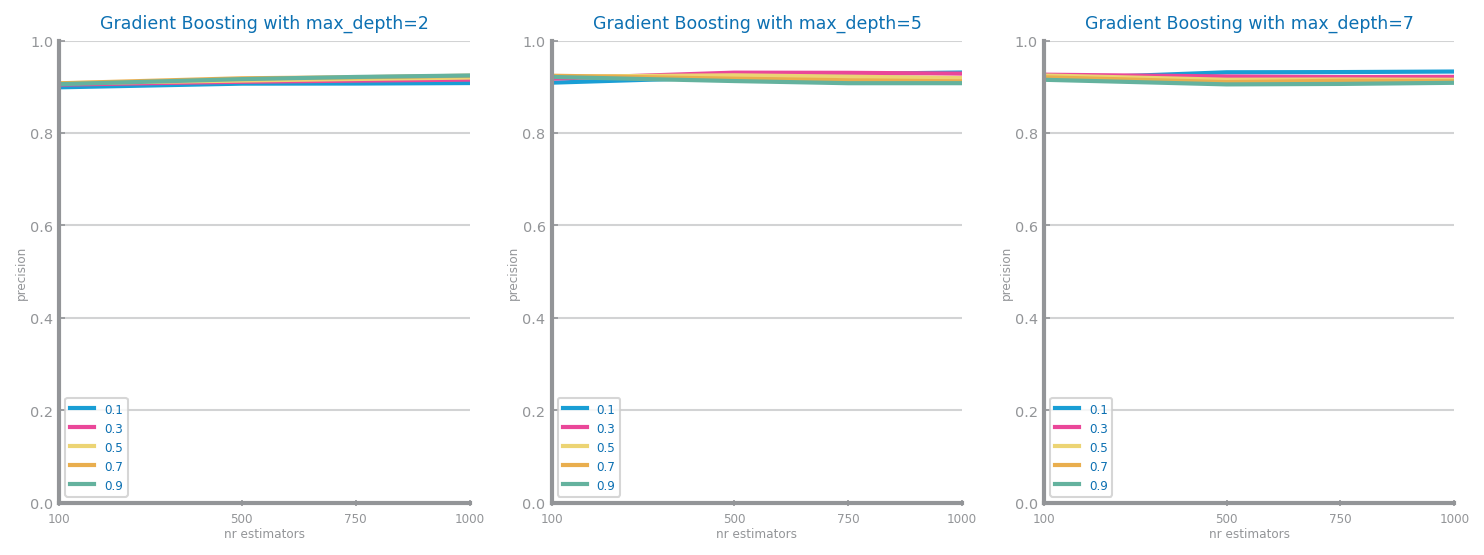

In [9]:
eval_metric="precision"
figure()
best_model, params = dslabs.gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

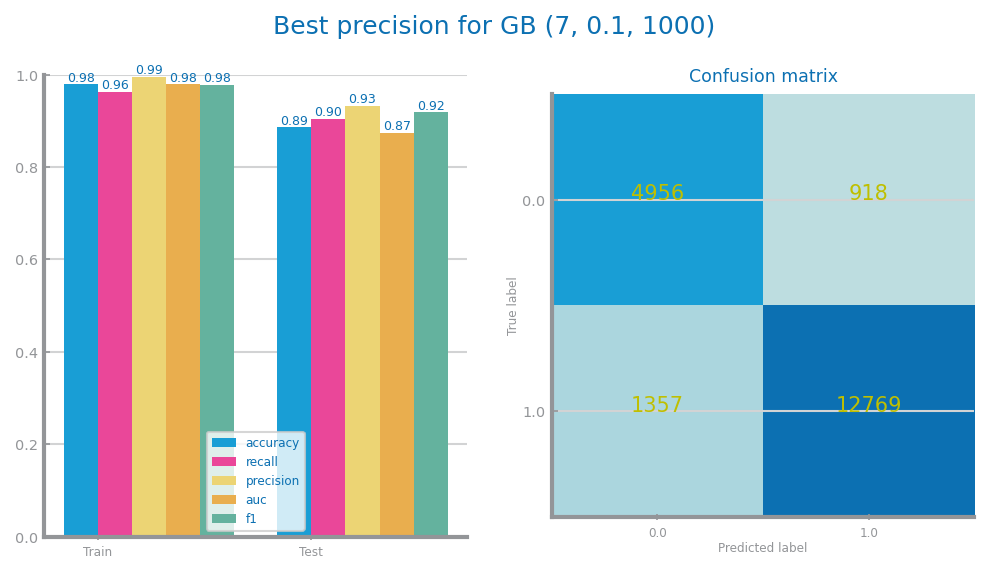

In [10]:
prd_trn: np.array = best_model.predict(trnX)
prd_tst: np.array = best_model.predict(tstX)
figure()
dslabs.plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'classification_images/gradiant_boosting/{file_tag}_gb_{params["name"]}_best_{params["metric"]}_eval.png')
show()

1. OutstandingDebt (0.32565910684424615)
2. CreditMix (0.12349543262673233)
3. Interest_Rate (0.07301850032358898)
4. Delay_from_due_date (0.06311541733502726)
5. Monthly_Inhand_Salary (0.05878755986515917)
6. Credit_History_Age (0.04901514508814359)
7. ChangedCreditLimit (0.04882280235459421)
8. Age (0.03170553400903885)
9. CreditUtilizationRatio (0.028428646290418243)
10. Num_Credit_Card (0.027562261811135712)
11. NumCreditInquiries (0.025941025244047844)
12. Num_Bank_Accounts (0.02592639732216269)
13. Month (0.024352656878348106)
14. Occupation (0.02173582196344094)
15. Payment_Behaviour (0.012672673122767679)
16. Personal Loan (0.007308877039058366)
17. Credit-Builder Loan (0.007134286011581856)
18. Auto Loan (0.006816206864512467)
19. Mortgage Loan (0.006544438017496193)
20. Payday Loan (0.006237566976682206)
21. Debt Consolidation Loan (0.006235585623695895)
22. Student Loan (0.005796730936794947)
23. Home Equity Loan (0.0055537226195362605)
24. Not Specified Loan (0.005281443835

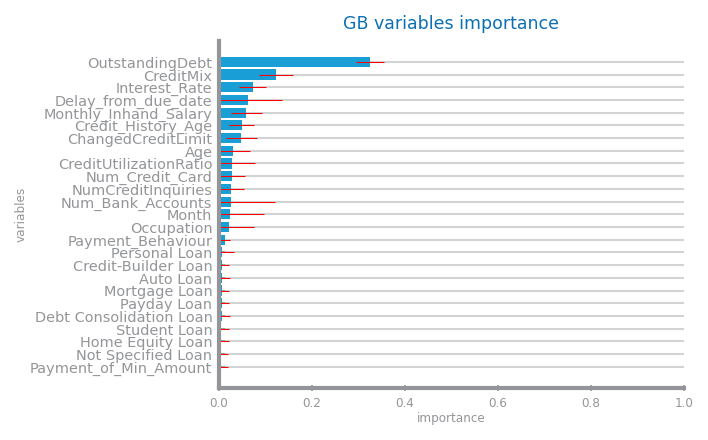

In [11]:
trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(np.std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = np.argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
dslabs.plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_vars_ranking.png")

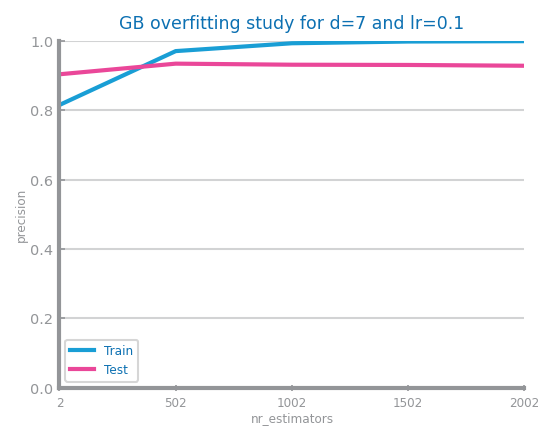

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "precision"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: np.array = clf.predict(tstX)
    prd_trn_Y: np.array = clf.predict(trnX)
    y_tst_values.append(dslabs.CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(dslabs.CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
dslabs.plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"classification_images/gradiant_boosting/{file_tag}_gb_{eval_metric}_overfitting.png")